In [67]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [68]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [69]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [70]:
PATH = "data/geese/"
sz=224

In [71]:
torch.cuda.is_available()

True

In [72]:
torch.backends.cudnn.enabled

True

## First look at pictures

In [73]:
os.listdir(PATH)

['valid', 'models', 'train', 'tmp']

In [74]:
os.listdir(f'{PATH}valid')

['china', 'canada']

In [75]:
files = os.listdir(f'{PATH}valid/canada')[:5]
files

['canada.103.jpg',
 'canada.104.jpg',
 'canada.106.jpg',
 'canada.102.jpg',
 'canada.105.jpg']

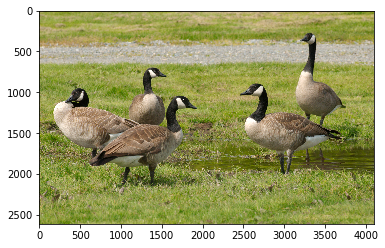

In [76]:
img = plt.imread(f'{PATH}valid/canada/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [77]:
img.shape

(2613, 4103, 3)

In [78]:
img[:4,:4]

array([[[173, 170,  93],
        [174, 171,  94],
        [175, 172,  95],
        [177, 171,  93]],

       [[171, 167,  93],
        [172, 168,  94],
        [174, 168,  92],
        [174, 168,  92]],

       [[170, 166,  93],
        [172, 166,  92],
        [172, 166,  90],
        [173, 167,  91]],

       [[173, 166,  94],
        [172, 165,  93],
        [172, 166,  92],
        [173, 167,  91]]], dtype=uint8)

## First model: quick start

In [79]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5)

epoch      trn_loss   val_loss   accuracy        
    0      0.764541   1.069051   0.5       
    1      0.723654   0.840033   0.583333        
    2      0.581321   0.653646   0.666667        
    3      0.477752   0.509944   0.833333        
    4      0.401962   0.413806   0.833333        



[array([0.41381]), 0.8333333134651184]

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [80]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [81]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['canada', 'china']

In [82]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(12, 2)

In [83]:
log_preds[:10]

array([[-0.32627, -1.27873],
       [-0.11292, -2.237  ],
       [-0.12839, -2.11621],
       [-0.17548, -1.8267 ],
       [-0.17015, -1.85493],
       [-0.28617, -1.39084],
       [-1.88233, -0.16515],
       [-1.11808, -0.39587],
       [-0.31261, -1.31504],
       [-1.47234, -0.26057]], dtype=float32)

In [84]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [85]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [86]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [87]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [88]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


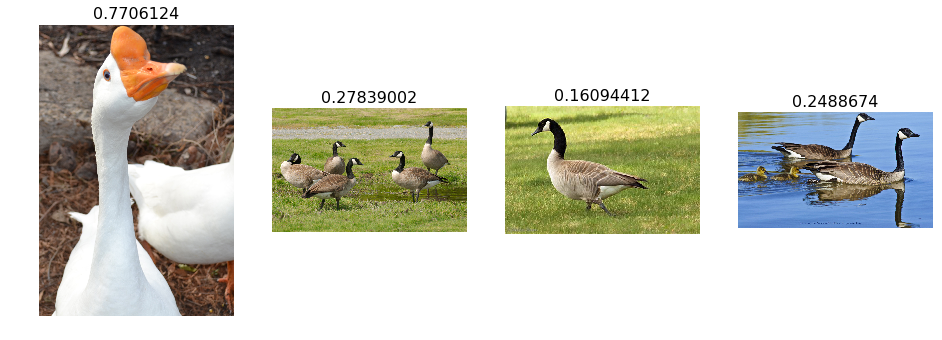

In [89]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [90]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

ValueError: Cannot take a larger sample than population when 'replace=False'

In [91]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct canadian geese


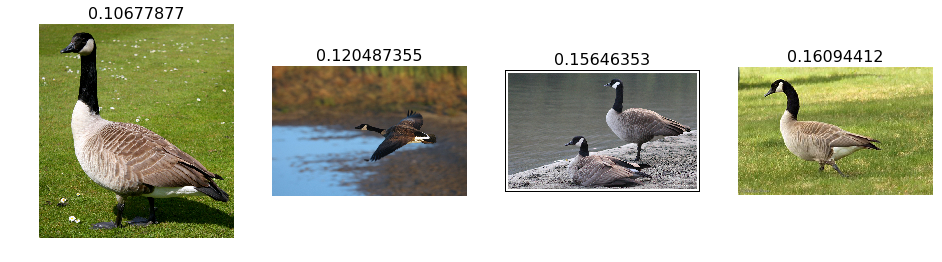

In [92]:
plot_val_with_title(most_by_correct(0, True), "Most correct canadian geese")

Most correct chinese geese


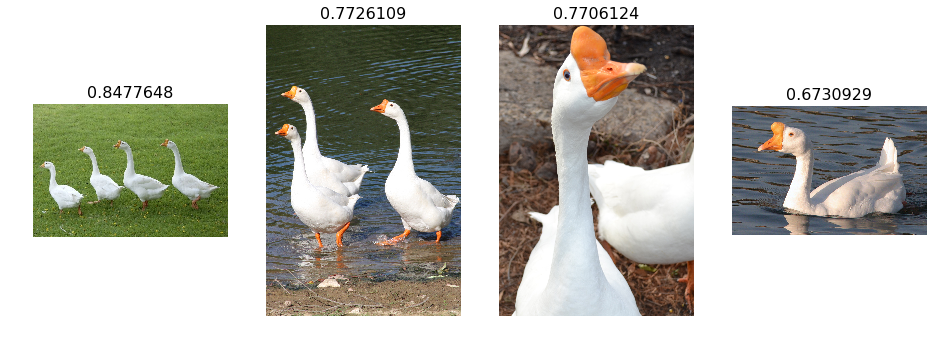

In [93]:
plot_val_with_title(most_by_correct(1, True), "Most correct chinese geese")

In [94]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect canadian geese")

Most incorrect canadian geese


<Figure size 1152x576 with 0 Axes>

Most incorrect chinese geese


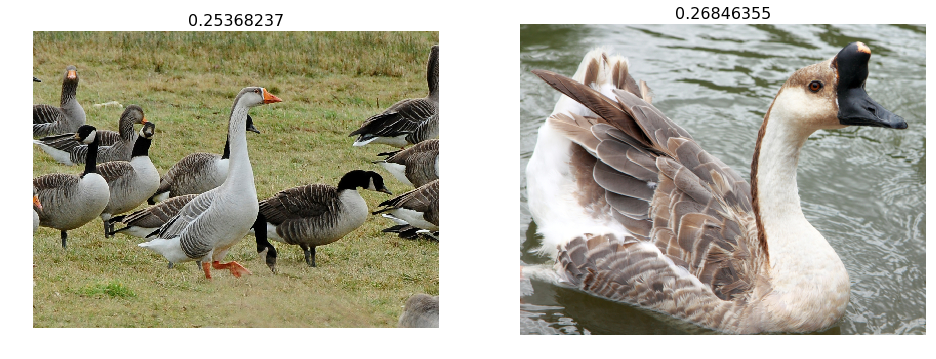

In [95]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect chinese geese")

Most uncertain predictions


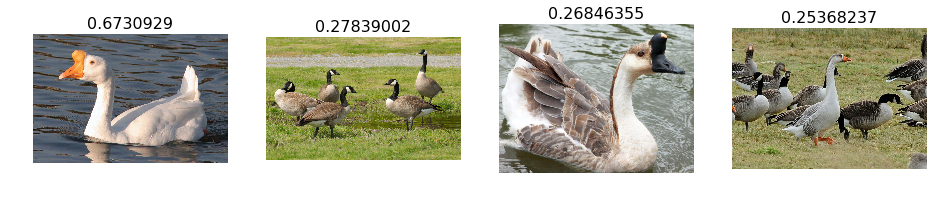

In [96]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")